<a href="https://colab.research.google.com/github/Akshat-Tripathi/AIHack20/blob/master/Signal_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compressor Analytics Dataset

Below are a few things to get you started with the Compressor Analytics dataset for AIHack! For more information see [here](https://drive.google.com/file/d/1ojYVHpabfkNz45nQqQLenyoaQbCmWdo4/view?usp=sharing).

In [1]:
# Download data - please only run this once
import urllib.request
import zipfile
import os

print("Starting download ...")
urls = [
    "https://github.com/aihack20/shell_challenge/releases/download/data/clean_dataset.zip",
    "https://github.com/aihack20/shell_challenge/releases/download/data/raw_dataset.zip",
]
os.makedirs("shell_data", exist_ok=True)
for url in urls:
    with urllib.request.urlopen(url) as src:
        with open("tmp.zip", "wb") as dest:
            dest.write(src.read())
    print("Unpacking archive ...")
    with zipfile.ZipFile("tmp.zip") as f:
        f.extractall("shell_data")
print("Done!")

Starting download ...
Unpacking archive ...
Unpacking archive ...
Done!


In [2]:
# Run this ONLY IF YOU USE GOOGLE COLAB
google_drive_dir = '/aihack20'

try:
    from google.colab import drive
    drive.mount("/content/drive")
    directory = "working_dir"
    if not os.path.exists(directory):
      os.symlink(os.path.join("drive", "My Drive", google_drive_dir), directory)
except ModuleNotFoundError as err:
    print("This only works on Google Colab. Skipping ...")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import DBSCAN
%pip install similaritymeasures
import similaritymeasures
plt.style.use('ggplot')

In [4]:
# Load the data (will take a short while)
clean_data = pd.read_csv("shell_data/clean_dataset.csv")
raw_data = pd.read_csv("shell_data/raw_dataset.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

## Your Hack ...

In [5]:
clean_data

,Temperature Indicating 0,Flow Rate Difference 1,Flow Rate Indicating 2,Flow Rate Indicating 3,Flow Rate Indicating 4,Flow Rate Indicating 5,Flow Rate Indicating 6,Flow Rate Indicating 7,Flow Rate Indicating 8,Flow Rate Transmitting 9,Flow Rate Transmitting 10,Flow Rate Transmitting 11,Flow Rate Transmitting 12,Flow Rate Actuating Element 13,Flow Rate Solenoid 14,Gauging Difference 15,Time Control Unknown 16,Level Indicating 17,Level Indicating 18,Pressure Controller 19,Pressure Difference 20,Pressure Difference 21,Pressure Difference 22,Pressure Difference 23,Pressure Difference 24,Pressure Difference 25,Pressure Difference 26,Pressure Difference 27,Pressure Difference 28,Pressure Difference 29,Pressure Difference 30,Pressure Difference 31,Pressure Difference 32,Pressure Indicating 33,Pressure Indicating 34,Pressure Indicating 35,Pressure Indicating 36,Pressure Indicating 37,Pressure Indicating 38,Pressure Indicating 39,...,Unknown Solenoid 323,Unknown Solenoid 324,Unknown Solenoid 325,Unknown Solenoid 326,Unknown Solenoid 327,Classified Status 328,Classified Indicating 329,Classified Indicating 330,Classified Indicating 331,Classified Indicating 332,Classified Indicating 333,Classified Indicating 334,Classified Indicating 335,Classified Indicating 336,Unknown Indicating 337,Unknown Indicating 338,Unknown Indicating 339,Unknown Indicating 340,Unknown Indicating 341,Unknown Indicating 342,Flow Rate Difference 343,Flow Rate Indicating 344,Flow Rate Actuating Element 345,Level Emergency Action 346,Pressure Difference 347,Pressure Difference 348,Pressure Difference 349,Pressure Difference 350,Pressure Indicating 351,Pressure Indicating 352,Pressure Indicating 353,Pressure Emergency Action 354,Temperature Controller 355,Temperature Indicating 356,Temperature Indicating 357,Temperature Indicating 358,Temperature Indicating 359,Temperature Indicating 360,Pressure Emergency Action 361,original_index
0,96.026969,134.058575,3.016896,5.499815,27221.60098,72829.950470,227.437532,5.672353,8.660389,259.164053,259.250694,37.604181,32.045362,2.979267,82.339927,0.0,11069.00855,26.312438,2.968154,8.387354,1.561507,0.111407,0.040897,0.017575,-0.009179,0.158100,0.199423,0.002104,4.278127,7.522407,2.926254,17.305795,0.0,2.294762,84.671409,28.102212,85.162853,6.644328,9.880568,7.794782,...,4.774930,11.267856,12.018494,3.600354,4.474426,0.0,4954.638333,7049.545236,16.576476,2096.470083,149.445182,6740.707903,0.703729,0.007709,-0.050000,-0.115212,0.090000,0.08,0.030000,0.0,733.562696,2353.957861,0.000000,46.569746,0.310399,0.361983,0.529558,0.006196,2.292604,27.922524,44.119015,44.053790,29.662350,54.554506,64.945662,25.450283,63.617557,64.978109,43.724690,0
1,95.987510,134.592346,3.020742,5.600833,27179.00250,71681.450820,227.170568,5.670112,8.642001,262.580608,263.893577,37.654943,32.106802,2.966380,82.376430,0.0,11074.03344,26.263372,3.052990,8.304424,1.560687,0.111684,0.041069,0.017791,-0.016854,0.157064,0.199661,0.002104,4.281026,7.480112,2.857404,17.300145,0.0,2.291194,84.703689,28.082687,85.124370,6.632087,9.872420,7.795228,...,4.474426,11.711700,12.018494,3.159676,4.474426,0.0,4938.391538,7019.052236,16.608910,2080.638000,149.340074,6725.873754,0.703762,0.006887,-0.050000,-0.115066,0.090000,0.08,0.030000,0.0,736.089958,2358.574785,0.000000,46.572425,0.307906,0.357844,0.528139,0.008542,2.297546,27.966855,44.053370,44.047508,29.694455,54.828519,64.916624,25.474713,63.724127,65.082058,43.772990,1
2,96.099651,133.920536,3.013397,5.797500,27383.78150,72524.834580,226.903604,5.664165,8.644843,259.783251,260.150397,37.560544,32.005114,2.959470,82.291741,0.0,11065.93960,26.272370,2.999251,8.290051,1.556959,0.111551,0.040897,0.016814,-0.022455,0.156462,0.198392,0.002085,4.279762,7.473612,2.985811,17.305048,0.0,2.286761,84.749601,28.069216,85.139617,6.594814,9.862027,7.806693,...,4.474426,11.328209,12.018494,3.163318,4.474426,0.0,4939.808129,7039.833792,16.619297,2099.810181,149.180346,6742.504121,0.704539,0.012337,-0.050000,-0.118318,0.090000,0.08,0.

In [0]:
anomalies = np.array([10634, 36136, 57280, 57618, 60545, 63144, 118665, 128524, 131118])
s = set(clean_data['original_index'])
t = set(raw_data.index)
idx_during_trip = np.array(list(t.difference(s)))

In [7]:
idx_where_trip_starts = idx_during_trip[np.where(np.diff(idx_during_trip) != 1)]
idx_where_trip_starts

array([   838,   1090,   3179,   4257,   4286,   5404,   6015,   6483,
         6751,   6909,   7807,  10699,  10765,  10836,  13016,  15924,
        16153,  17990,  18089,  18888,  23887,  25522,  26289,  31767,
        31799,  31906,  31935,  33692,  34583,  36019,  36111,  36240,
        38518,  39765,  39814,  40429,  42451,  42791,  43156,  45344,
        47561,  47693,  48274,  51855,  52379,  52451,  52705,  52830,
        54758,  56248,  57403,  57670,  57918,  58106,  60665,  60930,
        61121,  63314,  65675,  68885,  71086,  73967,  74206,  75292,
        76414,  77481,  87539,  87571,  87669,  87747,  87799,  89645,
        95729,  98932,  98967,  99487, 102133, 105309, 106676, 106910,
       107237, 108394, 108471, 110322, 110939, 111349, 112342, 114274,
       115072, 115144, 119996, 120111, 121031, 121064, 121313, 124372,
       124420, 128499, 128548, 129453])

In [8]:
anomalous_signals_at_trip = clean_data.loc[clean_data['original_index'].isin(anomalies)]
anomalous_signals_at_trip.dropna(axis = 1, inplace = True)
anomalous_signals_b4_trip = clean_data.loc[clean_data['original_index'].isin(anomalies-1)]
anomalous_signals_b4_trip.dropna(axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
len(anomalous_signals_at_trip)

9

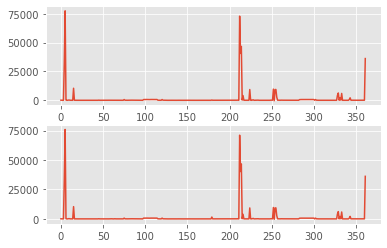

In [10]:
fig,ax = plt.subplots(2,1)
ax[0].plot(anomalous_signals_at_trip.iloc[1].values)
ax[1].plot(anomalous_signals_b4_trip.iloc[1].values)

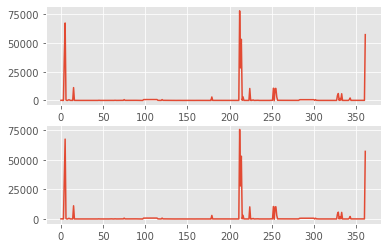

In [11]:
fig,ax = plt.subplots(2,1)
ax[0].plot(anomalous_signals_at_trip.iloc[2].values)
ax[1].plot(anomalous_signals_b4_trip.iloc[2].values)

In [0]:
def signal_near_trip(window):

  windows = np.arange(window)
  
  anomalous_signals_at_trip = clean_data.loc[clean_data['original_index'].isin(anomalies)]

  signals = []
  for i in range(len(anomalous_signals_at_trip)):
    signals.append([anomalous_signals_at_trip.iloc[i].values, anomalous_signals_b4_trip.iloc[i].values])
  signals = np.array(signals)

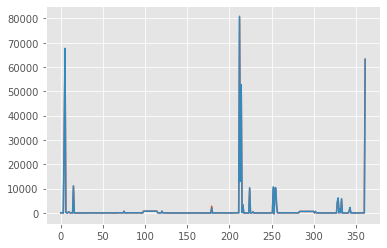

In [18]:
i = 5
plt.plot(signals[i,0])
plt.plot(signals[i,1])

In [16]:
i = 0
j = 0
t0 = np.zeros((len(signals[i,0]),2))           #similaritymeasures requires input data in this form
t0[:,0] = np.arange(len(signals[i,0]))
t0[:,1] = signals[i,0]


t1 = np.zeros((len(signals[j,1]),2))       #similaritymeasures form
t1[:,0] = np.arange(len(signals[j,1]))
t1[:,1] = signals[j,1]

print(similaritymeasures.curve_length_measure(t0,t1), similaritymeasures.dtw(t0,t1)[0])

32.769446476601715 80807.37977450398


In [0]:
def similarity_measure(x,y):

  t0 = np.zeros((len(x),2))           #similaritymeasures requires input data in this form
  t0[:,0] = np.arange(len(x))
  t0[:,1] = x

  t1 = np.zeros((len(y),2))       #similaritymeasures form
  t1[:,0] = np.arange(len(y))
  t1[:,1] = y

  return similaritymeasures.curve_length_measure(t0,t1)

In [130]:
similarity_measure(signals[0,0],signals[0,1])

32.769446476601715

In [0]:
def similarity_matrix(profiles):
  dm = np.zeros((len(profiles),len(profiles)))       #creating a similarity distance matrix to be populated
  print('Generating similarity distance matrix:')
  for i in tqdm(range(len(profiles))):
      
      t0 = np.zeros((len(profiles[i]),2))           #similaritymeasures requires input data in this form
      t0[:,0] = np.arange(len(profiles[i]))
      t0[:,1] = profiles[i]
      
      for j in range(len(profiles)):                #cycling through t_clipped_max, populating dm
          t1 = np.zeros((len(profiles[j]),2))       #similaritymeasures form
          t1[:,0] = np.arange(len(profiles[j]))
          t1[:,1] = profiles[j]
          dm[i,j] =similaritymeasures.dtw(t0,t1)[0]     #calculate dynamic time warping distance between t0 and t1
              
  return dm

In [0]:
def cluster(dm, eps, min_samples, directory, generate_clustered_files = True,generate_plots = False):
  clustering = DBSCAN(eps=eps, min_samples=min_samples, metric = 'precomputed').fit(dm)       #DBSCAN clustering. For more info on how it is implemented, refer to https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
  labels = clustering.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)     #label '-1' represents noise. So effectively, one less cluster if noise is present
  print('Estimated number of clusters: %d' % n_clusters_)
  if generate_clustered_files:    
        print('Generating clustered files:')
        for i in tqdm(set(labels)):
            
            idx = np.array(np.where(labels == i)).flatten()
            sub_dir = directory + '\eps %s min_samples %s\Cluster %s' %(eps,min_samples,i)
            
            if not os.path.exists(sub_dir):
                os.makedirs(sub_dir)
            
            if generate_plots:      #generate plots if called
                for _ in idx:
                    plt.clf()
                    plt.plot(transmission[_],color = 'k')
                    plt.savefig(sub_dir +'\%s.png' %list_of_files[_])
                
            np.savetxt(directory + '\\Cluster %s files.txt' %i,list_of_files[idx],fmt = '%s')   #generate clustered files.txt
    
  np.savetxt(directory + r'\eps %s min_samples %s\New Occultation dm 2.txt' %(eps,min_samples),dm)        #specify location to save dm given that it is very precious!!